In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split

sns.set_theme()

### Functions

In [66]:
# split a univariate sequence into samples
def split_sequence(sequence, window_size, step):
    X = list()
    for i in range(0, len(sequence), step):
        # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

def generate_pairs(data, labels, window_size, n_features):
    ### GENERATE PAIR SAMPLES FOR SIAMESE NETWORK ###

    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    random.seed(33)

    left_input = []
    right_input = []
    targets = []
    
    for i in range(len(data)):
        if labels[i] == 1:
            pairs = 30
        else:
            pairs = 1
        for _ in range(pairs):
            compare_to = i
            while compare_to == i:
                compare_to = random.randint(0,len(data)-1)
            left_input.append(data[i])
            right_input.append(data[compare_to])
            # targets.append(euclidean(data[i], data[compare_to]))
            if labels[i] == 1 and labels[compare_to] == 1:
                targets.append(0.)
            elif labels[i] == 1 or labels[compare_to] == 1:
                targets.append(1.)
            else:
                targets.append(0.)

    left_input = np.asarray(left_input).reshape(-1, window_size, n_features)
    right_input = np.asarray(right_input).reshape(-1, window_size, n_features)
    targets = np.asarray(targets)
    return left_input, right_input, targets

def generate_pairs_unbalanced(data, labels, window_size, n_features):
    ### GENERATE PAIR SAMPLES FOR SIAMESE NETWORK ###

    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    random.seed(33)

    left_input = []
    right_input = []
    targets = []
    pairs = 5
    
    for i in range(len(data)):
        for _ in range(pairs):
            compare_to = i
            while compare_to == i:
                compare_to = random.randint(0,len(data)-1)
            left_input.append(data[i])
            right_input.append(data[compare_to])
            # targets.append(euclidean(data[i], data[compare_to]))
            if labels[i] == 1 and labels[compare_to] == 1:
                targets.append(0.)
            elif labels[i] == 1 or labels[compare_to] == 1:
                targets.append(1.)
            else:
                targets.append(0.)

    left_input = np.asarray(left_input).reshape(-1, window_size, n_features)
    right_input = np.asarray(right_input).reshape(-1, window_size, n_features)
    targets = np.asarray(targets)
    return left_input, right_input, targets

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def SiamesNet():
    
    set_seed(33)
    
    left_input = Input((window_size, n_features))
    right_input = Input((window_size, n_features))

    lstmnet = Sequential([
        BatchNormalization(),
        LSTM(64, activation='relu', return_sequences=True, 
             input_shape=(window_size, n_features)),
        LSTM(16, activation='relu', 
             input_shape=(window_size, n_features))
    ])

    encoded_l = lstmnet(left_input)
    encoded_r = lstmnet(right_input)

    L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))

    L1_distance = L1_layer([encoded_l, encoded_r])
    drop = Dropout(0.2)(L1_distance)
    prediction = Dense(1,activation='sigmoid')(drop)
    model = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return model

### Pre-processing

In [67]:
dfs = []
for i in range(1, 68):
    dfs.append(pd.read_csv('./data/A1Benchmark/real_{}.csv'.format(i), index_col='timestamp'))

In [68]:
window_size = 6
step = window_size
n_features = 1
windows = split_sequence(dfs[8].value, window_size, step)
labels = split_sequence(dfs[8].is_anomaly, window_size, step)
labels = np.array([1. if 1 in label_list else 0. for label_list in labels])

In [69]:
train_windows, test_windows, train_labels, test_labels = train_test_split(windows, labels, random_state=33)

In [70]:
train_scaler, test_scaler = MinMaxScaler(), MinMaxScaler()
train_windows = train_scaler.fit_transform(train_windows)
test_windows = test_scaler.fit_transform(test_windows)

In [71]:
train_left_input, train_right_input, train_targets = generate_pairs(train_windows, train_labels, window_size, n_features)
test_left_input, test_right_input, test_targets = generate_pairs(test_windows, test_labels, window_size, n_features)
unb_train_left_input, unb_train_right_input, unb_train_targets = generate_pairs_unbalanced(train_windows, train_labels, window_size, n_features)
unb_test_left_input, unb_test_right_input, unb_test_targets = generate_pairs_unbalanced(test_windows, test_labels, window_size, n_features)

### Modeling

In [72]:
siamese_net = SiamesNet()
siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

siamese_net.fit([train_left_input, train_right_input], train_targets, validation_split=0.15, epochs=25)

Epoch 1/25


2023-03-20 20:18:56.518647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.6754

2023-03-20 20:19:01.978467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 8s 628ms/step - loss: 0.6906 - accuracy: 0.6754 - val_loss: 0.6933 - val_accuracy: 0.5610
Epoch 2/25
8/8 [==============================] - 3s 382ms/step - loss: 0.6856 - accuracy: 0.6886 - val_loss: 0.6927 - val_accuracy: 0.5610
Epoch 3/25
8/8 [==============================] - 3s 319ms/step - loss: 0.6794 - accuracy: 0.6754 - val_loss: 0.6914 - val_accuracy: 0.5610
Epoch 4/25
8/8 [==============================] - 2s 295ms/step - loss: 0.6743 - accuracy: 0.6842 - val_loss: 0.6902 - val_accuracy: 0.5610
Epoch 5/25
8/8 [==============================] - 3s 339ms/step - loss: 0.6643 - accuracy: 0.6886 - val_loss: 0.6871 - val_accuracy: 0.5610
Epoch 6/25
8/8 [==============================] - 3s 326ms/step - loss: 0.6545 - accuracy: 0.7149 - val_loss: 0.6823 - val_accuracy: 0.5610
Epoch 7/25
8/8 [==============================] - 3s 325ms/step - loss: 0.6364 - accuracy: 0.7412 - val_loss: 0.6751 - val_accuracy: 0.5610
Epoch 8/25
8/8 [===============

In [73]:
unb_siamese_net = SiamesNet()
unb_siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

unb_siamese_net.fit([unb_train_left_input, unb_train_right_input], unb_train_targets, validation_split=0.15, epochs=25)

Epoch 1/25


2023-03-20 20:20:00.885203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.9560

2023-03-20 20:20:12.131668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 13s 441ms/step - loss: 0.6547 - accuracy: 0.9560 - val_loss: 0.6614 - val_accuracy: 0.9562
Epoch 2/25
25/25 [==============================] - 8s 322ms/step - loss: 0.4971 - accuracy: 0.9741 - val_loss: 0.5211 - val_accuracy: 0.9562
Epoch 3/25
25/25 [==============================] - 8s 310ms/step - loss: 0.3101 - accuracy: 0.9741 - val_loss: 0.3882 - val_accuracy: 0.9562
Epoch 4/25
25/25 [==============================] - 8s 317ms/step - loss: 0.2817 - accuracy: 0.9741 - val_loss: 0.3741 - val_accuracy: 0.9562
Epoch 5/25
25/25 [==============================] - 8s 314ms/step - loss: 0.2424 - accuracy: 0.9754 - val_loss: 0.2879 - val_accuracy: 0.9562
Epoch 6/25
25/25 [==============================] - 8s 312ms/step - loss: 0.1940 - accuracy: 0.9767 - val_loss: 0.2007 - val_accuracy: 0.9781
Epoch 7/25
25/25 [==============================] - 7s 282ms/step - loss: 0.1521 - accuracy: 0.9767 - val_loss: 0.1386 - val_accuracy: 0.9781
Epoch 8/25
25/25

### Predictions

In [74]:
y_pred = siamese_net.predict([test_left_input, test_right_input])
unb_y_pred = unb_siamese_net.predict([unb_test_left_input, unb_test_right_input])

2023-03-20 20:23:19.617458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 145ms/step


2023-03-20 20:23:20.603058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 78ms/step


In [75]:
pred = ['fault' if i >= 0.99 else 'nofault' for i in y_pred]
real = ['fault' if i == 1 else 'nofault' for i in test_targets]
unb_pred = ['fault' if i >= 0.99 else 'nofault' for i in unb_y_pred]
unb_real = ['fault' if i == 1 else 'nofault' for i in unb_test_targets]

In [76]:
# os.environ['PYTHONHASHSEED'] = str(33)
# np.random.seed(33)
# random.seed(33)

# real = []
# pred = []
# rep = 4

# for j,i in enumerate(tqdm.tqdm(test_labels)):
    
#     test = test_windows[j]
    
#     nofault = np.random.choice(np.where(train_labels == 0)[0], rep)
#     nofault = train_windows[nofault]
#     nofault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:],s[np.newaxis,:]], verbose=0)) for s in nofault])

#     fault = np.random.choice(np.where(train_labels == 1)[0], rep)
#     fault = train_windows[fault]
#     fault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:],s[np.newaxis,:]], verbose=0)) for s in fault])
    
#     pred.append('nofault' if nofault_sim > fault_sim else 'fault')
#     real.append('nofault' if i == 0 else 'fault')
#     print(i)

<Axes: >

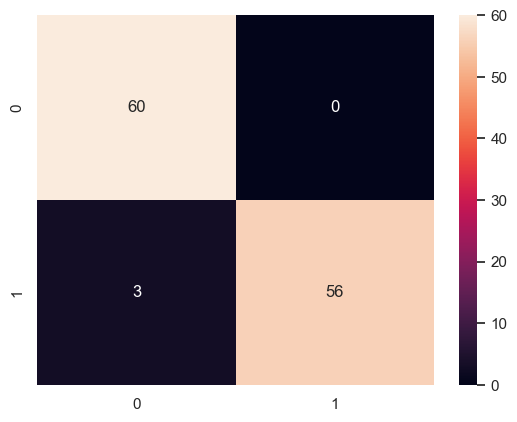

In [77]:
sns.heatmap(confusion_matrix(real, pred), annot=True)

<Axes: >

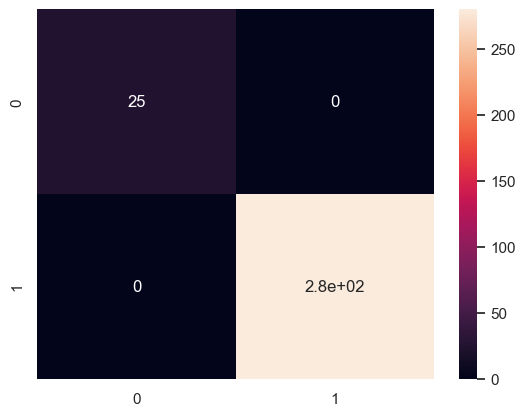

In [78]:
sns.heatmap(confusion_matrix(unb_real, unb_pred), annot=True)